In [1]:
import os
import glob

import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import utils
from model import BadModel, BadModel2
from dataset import SwingDataset, augment, oversample_minority

In [2]:
torch.__version__

'1.7.0'

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
path = "data/"

In [6]:
shot_types = ["Pull-hook", "Hook", "Pull", "Fade", "Straight", "Draw", "Push", "Slice" , "Push-slice"]

In [7]:
X_data, y_data = utils.load_data(path)

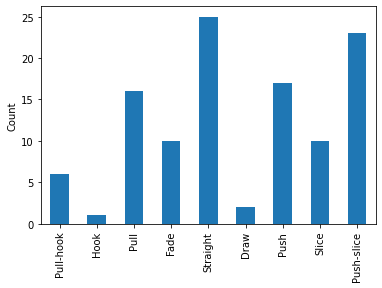

In [8]:
utils.plot_counts(y_data, xticks_label = shot_types)

In [9]:
use_oversampling = True

In [10]:
if use_oversampling:
    X_data, y_data = oversample_minority(X_data, y_data)
    print(X_data.shape, y_data.shape)


n = X_data.shape[0]

# GENERATE DATA SPLITS
train = 0.75
val = 0.20
test = 0.05

X_train = X_data[:int(n*train),:,:] 
y_train = y_data[:int(n*train),:]

X_val = X_data[int(n*train):int(n*(val+train)),:,:]
y_val = y_data[int(n*train):int(n*(val+train)),:]

X_test = X_data[-int(n*test):,:,:]
y_test = y_data[-int(n*test):,:]

# /GENERATE DATA SPLITS

(225, 6, 500) (225, 10)


In [11]:
X_train.shape, X_val.shape, X_test.shape

((168, 6, 500), (45, 6, 500), (11, 6, 500))

In [12]:
train_set = SwingDataset(X_train, y_train, augment=True, oversample = True)
val_set = SwingDataset(X_val, y_val, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)
test_set = SwingDataset(X_test, y_test, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)

In [13]:
np.save("norm_data/X_mean.npy", train_set.mean)
np.save("norm_data/X_std.npy", train_set.std)
np.save("norm_data/y_mean.npy", train_set.y_dist_mean)
np.save("norm_data/y_std.npy", train_set.y_dist_std)

In [14]:
train_set.mean == np.load("norm_data/X_mean.npy")

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

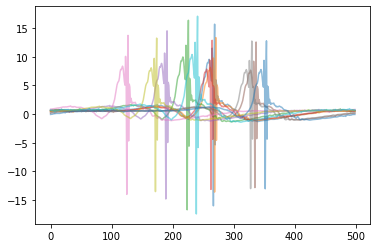

In [15]:
# test the data augmentation
plt.plot(train_set.X_data[0][0],alpha=0.5)
for _ in range(10):
    plt.plot(augment(train_set.X_data[0][0]), alpha=0.5)
plt.show()

In [16]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, drop_last=False, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, drop_last=False, shuffle=True)

In [17]:
bestmodel_file = os.path.join("weights", "best_model.pth")

model = BadModel2().to(device)
# model = MSResNet(input_channel=6, num_classes=10)

swing_type_loss = nn.CrossEntropyLoss()
# swing_type_loss = nn.BCEWithLogitsLoss()
#swing_type_loss = nn.BCELoss()
distance_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

losses = []
va_losses = []
val_losses_swing = []
val_losses_dist = []
num_epochs = 10
iter_idx = -1
best_va_loss = 9999 
train_interval = 50
val_interval = 50
report_interval = 10

In [18]:
loss_history = []
epochs = 400

train_losses = []
train_losses_swing = []
train_losses_dist = []


all_outputs = []


for e in range(epochs):
    prefix = "Epoch {:3d}: ".format(e)
#     for data in tqdm(train_loader, desc=prefix):
    for data in train_loader:
        print(e, end="\r", flush=True)
        iter_idx += 1
        X_train, y = data
        
        X_train = X_train.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_train.float())
        swing_loss = swing_type_loss(outputs[:, :-1], torch.max(y[:, :-1], 1)[1])
        # swing_loss = swing_type_loss(outputs[:, :-1], y[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y[:, -1:])
        loss =  swing_loss +  dist_loss

        if iter_idx % train_interval == 0:
            train_losses_swing.append(swing_loss)
            train_losses_dist.append(dist_loss)
            train_losses.append(loss)
            
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if iter_idx % val_interval == 0:
            va_loss = []
            val_loss_swing = []
            val_loss_dist = []
            model = model.eval()
            for data in val_loader:
                X_va, y_va = data
                X_va = X_va.to(device)
                y_va = y_va.to(device)
                with torch.no_grad():
                    outputs_va = model(X_va.float())               
                    swing_loss = swing_type_loss(outputs_va[:, :-1], torch.max(y_va[:, :-1], 1)[1])
                    # swing_loss = swing_type_loss(outputs_va[:, :-1], y_va[:, :-1])
                    dist_loss =  distance_loss(outputs_va[:, -1:], y_va[:, -1:])
                    loss = swing_loss + dist_loss
                    val_loss_swing += [swing_loss.cpu().numpy()]
                    val_loss_dist += [dist_loss.cpu().numpy()]
                    va_loss += [loss.cpu().numpy()]
                    
            model = model.train()
            va_loss = np.mean(va_loss)
            va_losses.append(va_loss)
            val_loss_swing = np.mean(val_loss_swing)
            val_loss_dist = np.mean(val_loss_dist)
            val_losses_swing += [val_loss_swing]
            val_losses_dist += [val_loss_dist]
            
            if va_loss < best_va_loss:
                best_va_loss = va_loss
                torch.save({
                    "iter_idx": iter_idx,
                    "best_va_loss": best_va_loss,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                }, bestmodel_file)

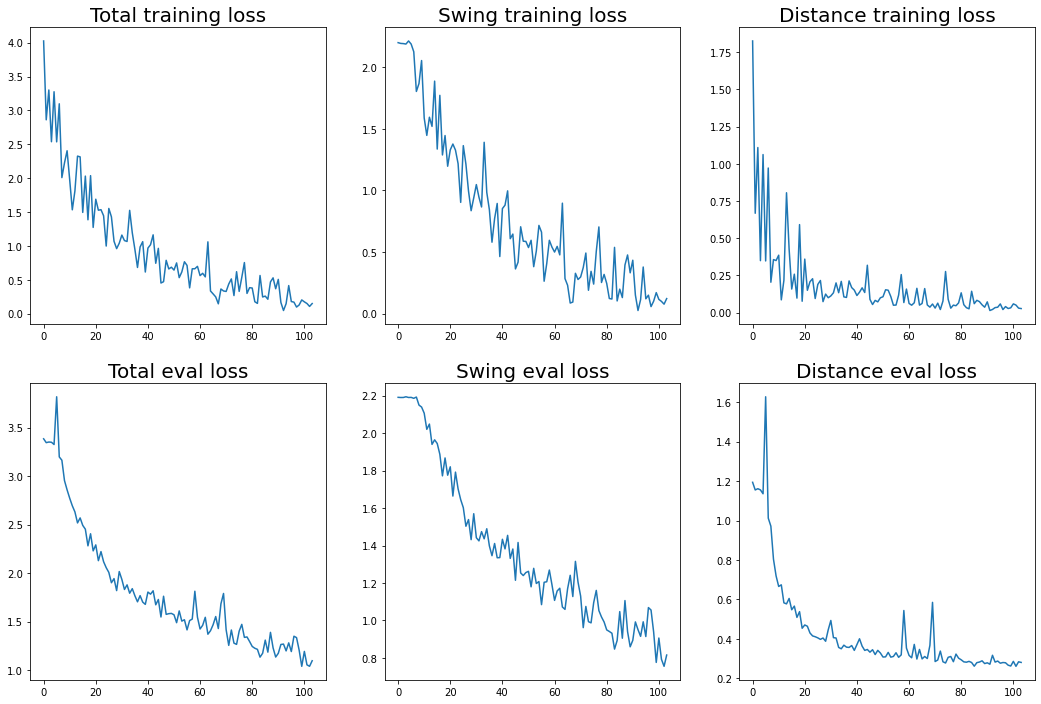

In [19]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Total training loss", fontsize = 20)
axs[0, 1].plot(train_losses_swing)
axs[0, 1].set_title("Swing training loss", fontsize = 20)
axs[0, 2].plot(train_losses_dist)
axs[0, 2].set_title("Distance training loss", fontsize = 20)

axs[1, 0].plot(va_losses)
axs[1, 0].set_title("Total eval loss", fontsize = 20)
axs[1, 1].plot(val_losses_swing)
axs[1, 1].set_title("Swing eval loss", fontsize = 20)
axs[1, 2].plot(val_losses_dist)
axs[1, 2].set_title("Distance eval loss", fontsize = 20)
fig.set_figheight(12)
fig.set_figwidth(18)

In [20]:
def print_preds(predictions, truth, mean, std):
    for pred, true in zip(predictions, truth):
        pred_distance = pred[-1] * std + mean
        pred_argmax = torch.argmax(pred[:-1])
        pred_shot_type = shot_types[pred_argmax]
        print(f"Pred: {pred_shot_type} {round(pred_distance.item())}yds")
        
        true_distance = true[-1] * std + mean
        true_argmax = torch.argmax(true[:-1])
        true_shot_type = shot_types[true_argmax]
        
        print(f"True: {true_shot_type} {round(true_distance.item())}yds")
        print()

In [21]:
print_preds(outputs, y, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Push 130yds
True: Push 130yds

Pred: Hook 99yds
True: Hook 100yds

Pred: Fade 134yds
True: Fade 140yds

Pred: Pull-hook 140yds
True: Pull-hook 140yds

Pred: Push 129yds
True: Push 140yds

Pred: Push 143yds
True: Push 140yds

Pred: Straight 146yds
True: Straight 150yds

Pred: Fade 120yds
True: Fade 115yds

Pred: Draw 140yds
True: Draw 145yds

Pred: Push-slice 76yds
True: Push-slice 70yds

Pred: Pull-hook 136yds
True: Pull-hook 140yds

Pred: Slice 135yds
True: Slice 140yds

Pred: Push 86yds
True: Push 90yds

Pred: Push 111yds
True: Push 100yds

Pred: Pull 115yds
True: Pull 115yds



In [22]:
print_preds(outputs_va, y_va, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Slice 129yds
True: Slice 140yds



# Test

In [34]:
model = BadModel2().to(device)
model.load_state_dict(torch.load(bestmodel_file)['model'])


<All keys matched successfully>

In [35]:
# normalization moved to the dataloader
# X_test_norm = norm(X_test, train_mean, train_std)
# y_test_norm = y_test.copy()
# y_test_norm[:, -1] -= y_distance_mean
# y_test_norm[:, -1] /= y_distance_std

test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, drop_last=False)

In [36]:
swing_losses, dist_losses, total_losses, = [], [], []
model = model_.eval()
idx = 0

test_out = []
true_out = []
test_shot_types = []
true_shot_types = []

with torch.no_grad():
    for data in test_loader:
        idx += 1
        x_test, y_test = data
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        outputs = model(x_test.float())
        
        swing_loss = swing_type_loss(outputs[:, :-1], torch.max(y_test[:, :-1], 1)[1])
        # swing_loss = swing_type_loss(outputs[:, :-1], y_test[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y_test[:, -1:])
        total_loss = swing_loss + dist_loss
        
        swing_losses += [swing_loss.cpu().numpy()]
        dist_losses += [dist_loss.cpu().numpy()]
        total_losses += [total_loss.cpu().numpy()]
        
        print("Test example %d: swing_loss = %f, dist_loss = %f" % (idx, swing_losses[idx-1], dist_losses[idx-1]))
  
        test_out.append(outputs[0])
        true_out.append(y_test[0])
        test_shot_types.append(np.argmax(outputs[:, :-1]).item())
        true_shot_types.append(np.argmax(y_test[:, :-1]).item())
#         test_shot_dist.append(outputs[:,0].item())
#         true_shot_dist.append(y_test[:,0].item())
    
    avg_swing_loss = np.mean(swing_losses)
    avg_dist_loss = np.mean(dist_losses)
    avg_total_loss = np.mean(total_losses)
    print()
    print("Out of %d test examples: avg_swing_loss = %f, avg_dist_loss = %f, avg_total_loss = %f" % (idx, avg_swing_loss, avg_dist_loss, avg_total_loss))

Test example 1: swing_loss = 0.046673, dist_loss = 0.021635
Test example 2: swing_loss = 0.151363, dist_loss = 0.004465
Test example 3: swing_loss = 0.914424, dist_loss = 0.019428
Test example 4: swing_loss = 0.008792, dist_loss = 0.010641
Test example 5: swing_loss = 0.008792, dist_loss = 0.010641
Test example 6: swing_loss = 1.267551, dist_loss = 0.161651
Test example 7: swing_loss = 0.941244, dist_loss = 0.000102
Test example 8: swing_loss = 0.006974, dist_loss = 0.000688
Test example 9: swing_loss = 2.239948, dist_loss = 0.016590
Test example 10: swing_loss = 0.407645, dist_loss = 0.045067
Test example 11: swing_loss = 0.164145, dist_loss = 0.009966

Out of 11 test examples: avg_swing_loss = 0.559777, avg_dist_loss = 0.027352, avg_total_loss = 0.587129


In [37]:
print_preds(test_out, true_out, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Push-slice 65yds
True: Push-slice 60yds

Pred: Push-slice 78yds
True: Push-slice 80yds

Pred: Pull-hook 75yds
True: Push-slice 70yds

Pred: Hook 103yds
True: Hook 100yds

Pred: Hook 103yds
True: Hook 100yds

Pred: Push 97yds
True: Push 110yds

Pred: Fade 140yds
True: Straight 140yds

Pred: Draw 121yds
True: Draw 120yds

Pred: Slice 119yds
True: Push-slice 115yds

Pred: Fade 128yds
True: Fade 135yds

Pred: Pull-hook 67yds
True: Pull-hook 70yds



In [38]:
def get_accuracy(predictions, truth, mean, std):
    acc = 0
    for pred, true in zip(predictions, truth):
        pred_argmax = torch.argmax(pred[:-1])
        pred_shot_type = shot_types[pred_argmax]
        
        true_argmax = torch.argmax(true[:-1])
        true_shot_type = shot_types[true_argmax]
        
        acc+=true_argmax == pred_argmax
    return acc / len(predictions)



def get_MSE(predictions, truth, mean, std):
    mse = 0
    for pred, true in zip(predictions, truth):
        pred_distance = pred[-1] * std + mean
        true_distance = true[-1] * std + mean
    mse += (pred_distance - true_distance)**2
    return mse**0.5
        

In [39]:
get_accuracy(test_out, true_out, train_set.y_dist_mean, train_set.y_dist_std)

tensor(0.7273)

In [40]:
get_MSE(test_out, true_out, train_set.y_dist_mean, train_set.y_dist_std)

tensor(3.2908)

In [30]:

!pip3 install seaborn --user



You are using pip version 19.0.3, however version 20.3.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
from sklearn.metrics import confusion_matrix
#import seaborn as sn
from sklearn.metrics import plot_confusion_matrix

In [32]:
cm = confusion_matrix(true_shot_types, test_shot_types)
cm

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 3]])

In [33]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

NameError: name 'sn' is not defined

<Figure size 720x504 with 0 Axes>

# for debugging...

In [ ]:
import torch.nn.functional as F

class BadModel2(nn.Module):

    def __init__(self):
        super(BadModel2, self).__init__()
        # kernel
        self.conv1 = nn.Conv2d(1, 10, (3, 20), stride=(3, 5))
        self.conv2 = nn.Conv2d(10, 16, (2, 15), stride=(1, 3))

        self.fc1_cls = nn.Linear(16 * 6, 120)  
        self.fc2_cls = nn.Linear(120, 84)
        self.fc3_cls = nn.Linear(84, 9)
        # self.softmax = nn.Softmax(dim=1)
        
        self.fc1_dist = nn.Linear(16 * 6, 50)
        self.fc2_dist = nn.Linear(50, 1)
        
        self.dropout = nn.Dropout(0)

    def forward(self, x):
        
        x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (1,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (1,2))
                        
        x = x.view(-1, self.num_flat_features(x))
        
        x_cls = F.relu(self.fc1_cls(x))
        x_cls = self.dropout(x_cls)
        x_cls = F.relu(self.fc2_cls(x_cls))
        x_cls = self.dropout(x_cls)
        x_cls = self.fc3_cls(x_cls)
        # x_cls = self.softmax(x_cls)

        x_dist = F.relu(self.fc1_dist(x))
        x_cls = self.dropout(x_dist)
        x_dist = self.fc2_dist(x_dist)

        x = torch.cat([x_cls, x_dist], axis=1)
        
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
inputs = torch.rand(4,6,500)

In [ ]:
inputs = torch.rand(4,6,500)
m = BadModel2()

In [ ]:
inputs = torch.rand(4,6,500)
m = BadModel2()
m(inputs)

In [ ]:
l = nn.MSELoss()
l()